# Overview

This notebook implements an early evaluation of the strength of the theoretical gateway aggregator model using experimental results.
Compares single experimental setups with the Pinciroli's (2023) theoretical results to generate an intuition of their relationship.

It visualizes the results, calculates the _mean average (percentage) error_ between the results, suggesting how 'off' the results are.
It also calculates Pearson's $r$ to understand the correlation between results.


In [1]:
# Forces the notebook to always reload packages.
%reload_ext autoreload
%autoreload 2

import datetime
import json
import os
import typing

import pandas as pd
import numpy as np
from scipy.stats import spearmanr

import gssi_experiment.util.util as util
import gssi_experiment.util.prometheus_raw_data_helper as prom_raw_data_helper
import gssi_experiment.util.notebook_helper as nb_helper
import gssi_experiment.util.stat_helper as stat_helper

pincirollis_data_path = "/workspaces/muBench-experiment/gssi_experiment/pipes_and_filters/pipes_and_filters_joint/Core2_N50.csv"
synth_df = pd.read_csv(pincirollis_data_path, header=0)
synth_df.describe()

base_path = "/workspaces/muBench-experiment/gssi_experiment/pipes_and_filters/pipes_and_filters_joint/results/pinciroli_replication_22_jan_24"

fig_path = "/workspaces/muBench-experiment/gssi_experiment/pipes_and_filters/pipes_and_filters_joint/figures/pinciroli_replication_22_jan_24/"

intensity_key = "freemium_intensity"

## Dataframe creation


In [2]:
TIME_FORMAT = "%Y-%m-%dT%H:%M:%S.000Z"
TIMEFORMAT_2 = "%Y-%m-%d %H:%M:%S"

service_cols = ["s1", "s2", "s3", "s4"]

def get_data_points() -> typing.Iterator:
    for experiment_folder in util.iterate_through_nested_folders(
        base_path, max_depth=2
    ):
        # Calculates delay data
        mubench_file = f"{experiment_folder}/mubench_results.csv"
        exp_df = pd.read_csv(mubench_file, header=0)
        avg_latency = np.average(exp_df["latency_ms"])

        # Reads metadata to calculate intensity
        meta_path = f"{experiment_folder}/metadata.json"
        with open(meta_path, "r", encoding="utf-8") as meta_file:
            metadata = json.loads(meta_file.read())

        # Filters out non-1CPU entries.
        shared_cpu_limit = metadata["cmd_arguments"]["shared_cpu_limits"]
        if shared_cpu_limit != '2000m':
            continue

        cpu_limit = metadata["cmd_arguments"]["cpu_limit"]
        replicas = metadata["cmd_arguments"]["replicas"]
        max_steps = metadata["cmd_arguments"]["simulation_steps"]
        # HACK: add this to the metadata.
        step = int(os.path.basename(experiment_folder).split("_")[0])
        intensity = step / max_steps

        # Calculates CPU utilization data.
        start_time = datetime.datetime.strptime(metadata["start_time"], TIME_FORMAT)
        end_time = datetime.datetime.strptime(metadata["end_time"], TIME_FORMAT)
        utilization_data = prom_raw_data_helper.calculate_average_cpu_time(
            experiment_folder, service_cols, start_time, end_time
        )

        data_point = [
            step,
            max_steps,
            intensity,
            avg_latency,
            cpu_limit,
            shared_cpu_limit,
            replicas,
            metadata["start_time"],
            metadata["end_time"],
            *utilization_data,
        ]
        yield data_point


cols = [
    "step",
    "max_step",
    intensity_key,
    "avg_latency_ms",
    "cpu_limit",
    'shared_cpu_limit',
    "replicas",
    "experiment_start_time",
    "experiment_end_time",
]
cpu_util_format = "cpu_utilization_{service}"
cpu_columns = [cpu_util_format.format(service=service) for service in service_cols]
cols.extend(cpu_columns)

data_points = get_data_points()

df = pd.DataFrame(data_points, columns=cols)

old_df_len = len(df)
df = df.dropna()
new_df_len = len(df)
if new_df_len != old_df_len:
    print("!!!SOME ROWS WERE REMOVED BECAUSE THEY ARE NAN!!!")
    print(f"The row count was {old_df_len} and now is {new_df_len}.")

df.describe()

Retrying to calculate averages with services: ['s1.1', 's2', 's3', 's4']
Retrying to calculate averages with services: ['s1.1', 's2', 's3', 's4']
Updating initial services to: ['s1', 's2.1', 's3', 's4']
Retrying to calculate averages with services: ['s1', 's2.1', 's3.1', 's4']


,step,max_step,freemium_intensity,avg_latency_ms,replicas,cpu_utilization_s1,cpu_utilization_s2,cpu_utilization_s3,cpu_utilization_s4
count,36.000000,36.0,36.00000,36.000000,36.0,36.000000,36.000000,36.000000,36.000000
mean,2.500000,5.0,0.50000,549.166696,1.0,1.281353,1.482956,0.642952,0.618301
std,1.732051,0.0,0.34641,111.042044,0.0,0.280288,0.330120,0.386607,0.394971
min,0.000000,5.0,0.00000,387.074121,1.0,0.832408,0.913122,0.001911,0.001662
25%,1.000000,5.0,0.20000,442.234106,1.0,1.095675,1.309605,0.266308,0.223732
50%,2.500000,5.0,0.50000,543.269106,1.0,1.271805,1.498721,0.803243,0.727890
75%,4.000000,5.0,0.80000,656.852701,1.0,1.581608,1.760974,0.974847,0.976271
max,5.000000,5.0,1.00000,719.474960,1.0,1.688264,1.975651,0.999353,0.994057


Divides CPU usage of the resources with 2 CPUs in half to make them comparable with the synthetic results.

In [3]:
df.loc[:, 'cpu_utilization_s1'] = df['cpu_utilization_s1'].transform(lambda x: x / 2)
df.loc[:, 'cpu_utilization_s2'] = df['cpu_utilization_s2'].transform(lambda x: x / 2)

In [4]:
synth_cols = ["N_A", "R0", "N_B", "Ut1", "Ut2", "Ut3_A", "Ut3_B"]
pinc_df = synth_df[synth_cols]
pinc_df.loc[:, intensity_key] = pinc_df["N_A"] / (pinc_df["N_A"] + pinc_df["N_B"])
pinc_df = pinc_df.drop("N_A", axis=1)

df = pd.merge(df, pinc_df, on=intensity_key)

df.describe()

/tmp/ipykernel_58623/4279423745.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pinc_df.loc[:, intensity_key] = pinc_df["N_A"] / (pinc_df["N_A"] + pinc_df["N_B"])


,step,max_step,freemium_intensity,avg_latency_ms,replicas,cpu_utilization_s1,cpu_utilization_s2,cpu_utilization_s3,cpu_utilization_s4,R0,N_B,Ut1,Ut2,Ut3_A,Ut3_B
count,36.000000,36.0,36.00000,36.000000,36.0,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,2.500000,5.0,0.50000,549.166696,1.0,0.640677,0.741478,0.642952,0.618301,385.747577,25.000000,0.680631,0.812838,0.715899,0.725209
std,1.732051,0.0,0.34641,111.042044,0.0,0.140144,0.165060,0.386607,0.394971,102.544639,17.320508,0.159810,0.195117,0.355287,0.365837
min,0.000000,5.0,0.00000,387.074121,1.0,0.416204,0.456561,0.001911,0.001662,293.558123,0.000000,0.398786,0.453734,0.000000,0.000000
25%,1.000000,5.0,0.20000,442.234106,1.0,0.547837,0.654803,0.266308,0.223732,306.354252,10.000000,0.542666,0.670968,0.592485,0.557986
50%,2.500000,5.0,0.50000,543.269106,1.0,0.635903,0.749360,0.803243,0.727890,331.771417,25.000000,0.749026,0.893611,0.852044,0.896635
75%,4.000000,5.0,0.80000,656.852701,1.0,0.790804,0.880487,0.974847,0.976271,497.587200,40.000000,0.816053,0.976653,0.998824,1.000000
max,5.000000,5.0,1.00000,719.474960,1.0,0.844132,0.987826,0.999353,0.994057,553.443056,50.000000,0.828231,0.988448,1.000000,1.000000


### Reconstruction

In [5]:
averaged_columns = set([*synth_cols, *cpu_columns, "avg_latency_ms", "R0"])
averaged_columns.remove("N_A")

#### Averaged DF

In [6]:
# Calculates an averaged dataset.
avg_df = nb_helper.to_averaged_df(
    df,
    group_on=[intensity_key],
    averaged_columns=averaged_columns,
)

avg_df

averaged_columns={'Ut1', 'avg_latency_ms', 'Ut3_B', 'cpu_utilization_s2', 'R0', 'cpu_utilization_s1', 'cpu_utilization_s3', 'Ut2', 'N_B', 'Ut3_A', 'cpu_utilization_s4'}


,step,max_step,avg_latency_ms,replicas,cpu_utilization_s1,cpu_utilization_s2,cpu_utilization_s3,cpu_utilization_s4,R0,N_B,...,std_cpu_utilization_s2,std_cpu_utilization_s3,std_cpu_utilization_s4,std_R0,std_N_B,std_Ut1,std_Ut2,std_Ut3_A,std_Ut3_B,freemium_intensity
0,0.0,5.0,657.668260,1.0,0.424355,0.464494,0.004320,0.975518,497.587200,50.0,...,0.003942,0.001674,0.003712,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,5.0,519.912743,1.0,0.595844,0.665828,0.264709,0.977662,325.410274,40.0,...,0.055756,0.007282,0.010989,0.0,0.0,0.0,0.0,0.0,0.0,0.2
2,2.0,5.0,402.496848,1.0,0.804912,0.901642,0.687764,0.957071,293.558123,30.0,...,0.037740,0.037142,0.046372,0.0,0.0,0.0,0.0,0.0,0.0,0.4
3,3.0,5.0,441.693588,1.0,0.800246,0.934633,0.935479,0.572831,306.354252,20.0,...,0.037425,0.035256,0.021786,0.0,0.0,0.0,0.0,0.0,0.0,0.6
4,4.0,5.0,564.689454,1.0,0.667161,0.801369,0.983121,0.223347,338.132560,10.0,...,0.039023,0.015013,0.003032,0.0,0.0,0.0,0.0,0.0,0.0,0.8
5,5.0,5.0,708.539282,1.0,0.551542,0.680900,0.982321,0.003374,553.443056,0.0,...,0.006950,0.009316,0.001350,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Create normalized dataframe

Each entry in the data frame is normalized using the min and max values of the averaged dataframe.

In [7]:
# Calculates a normalized data set
norm_df = df.copy()

for col in averaged_columns:
    min_y, max_y = min(avg_df[col]), max(avg_df[col])
    norm_df.loc[:, col] = norm_df[col].transform(
        lambda y: nb_helper.normalize(y, min_y, max_y)
    )

norm_df.describe()

,step,max_step,freemium_intensity,avg_latency_ms,replicas,cpu_utilization_s1,cpu_utilization_s2,cpu_utilization_s3,cpu_utilization_s4,R0,N_B,Ut1,Ut2,Ut3_A,Ut3_B
count,36.000000,36.0,36.00000,36.000000,36.0,36.000000,36.000000,36.000000,36.000000,36.000000,36.00000,3.600000e+01,3.600000e+01,36.000000,36.000000
mean,2.500000,5.0,0.50000,0.479247,1.0,0.568435,0.589153,0.652464,0.631155,0.354732,0.50000,6.563014e-01,6.715806e-01,0.715899,0.725209
std,1.732051,0.0,0.34641,0.362832,0.0,0.368260,0.351087,0.394980,0.405394,0.394577,0.34641,3.721308e-01,3.648985e-01,0.355287,0.365837
min,0.000000,5.0,0.00000,-0.050394,1.0,-0.021419,-0.016873,-0.002461,-0.001757,0.000000,0.00000,1.292625e-16,1.038146e-16,0.000000,0.000000
25%,1.000000,5.0,0.20000,0.129842,1.0,0.324478,0.404792,0.267662,0.226173,0.049238,0.20000,3.350368e-01,4.062629e-01,0.592485,0.557986
50%,2.500000,5.0,0.50000,0.459976,1.0,0.555890,0.605919,0.816226,0.743636,0.147039,0.50000,8.155640e-01,8.226396e-01,0.852044,0.896635
75%,4.000000,5.0,0.80000,0.831113,1.0,0.962929,0.884830,0.991547,0.998572,0.785075,0.80000,9.716434e-01,9.779412e-01,0.998824,1.000000
max,5.000000,5.0,1.00000,1.035733,1.0,1.103061,1.113142,1.016583,1.016827,1.000000,1.00000,1.000000e+00,1.000000e+00,1.000000,1.000000


#### Create normalized averaged data frame

In [8]:
# Calculates a normalized averaged dataset.
avg_norm_df = avg_df.copy()
for col in averaged_columns:
    avg_norm_df, min_y, max_y = nb_helper.normalize_field_and_yield_min_max(
        avg_norm_df, col
    )
    delta_y = max_y - min_y
    std_col = f"std_{col}"
    avg_norm_df.loc[:, std_col] = avg_norm_df[std_col].transform(
        lambda y: y / delta_y
    )

avg_norm_df.describe()

,step,max_step,avg_latency_ms,replicas,cpu_utilization_s1,cpu_utilization_s2,cpu_utilization_s3,cpu_utilization_s4,R0,N_B,...,std_cpu_utilization_s2,std_cpu_utilization_s3,std_cpu_utilization_s4,std_R0,std_N_B,std_Ut1,std_Ut2,std_Ut3_A,std_Ut3_B,freemium_intensity
count,6.000000,6.0,6.000000,6.0,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,6.000000,6.000000,6.000000,6.0,6.0,6.0,6.0,6.0,6.0,6.000000
mean,2.500000,5.0,0.479247,1.0,0.568435,0.589153,0.652464,0.631155,0.354732,0.500000,...,0.064108,0.017995,0.014924,0.0,0.0,0.0,0.0,0.0,0.0,0.500000
std,1.870829,0.0,0.390278,0.0,0.389555,0.371666,0.426017,0.437320,0.426192,0.374166,...,0.043279,0.015352,0.017790,0.0,0.0,0.0,0.0,0.0,0.0,0.374166
min,0.000000,5.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.008386,0.001710,0.001385,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
25%,1.250000,5.0,0.191972,1.0,0.363317,0.436259,0.374083,0.315455,0.067569,0.250000,...,0.030988,0.007959,0.003286,0.0,0.0,0.0,0.0,0.0,0.0,0.250000
50%,2.500000,5.0,0.456813,1.0,0.544327,0.588423,0.824786,0.781675,0.147039,0.500000,...,0.079939,0.012428,0.007545,0.0,0.0,0.0,0.0,0.0,0.0,0.500000
75%,3.750000,5.0,0.757825,1.0,0.900312,0.876506,0.987219,0.993066,0.631685,0.750000,...,0.082322,0.030849,0.019590,0.0,0.0,0.0,0.0,0.0,0.0,0.750000
max,5.000000,5.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.118596,0.037946,0.047596,0.0,0.0,0.0,0.0,0.0,0.0,1.000000


# Request Delay


## Visualization


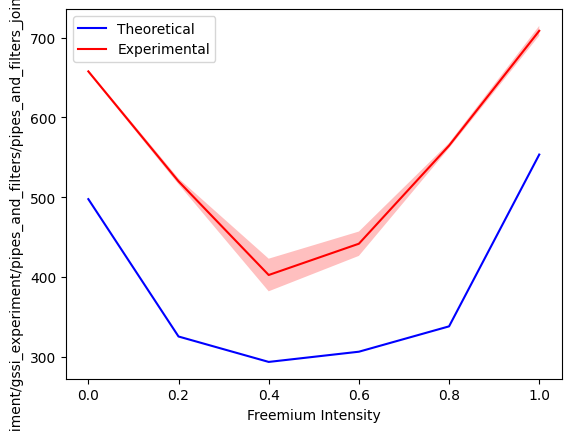

In [9]:
output_path = f'{fig_path}/2cpu_req_delay_abs.png'
nb_helper.create_figure(avg_df, intensity_key, "R0", "avg_latency_ms", output_path)

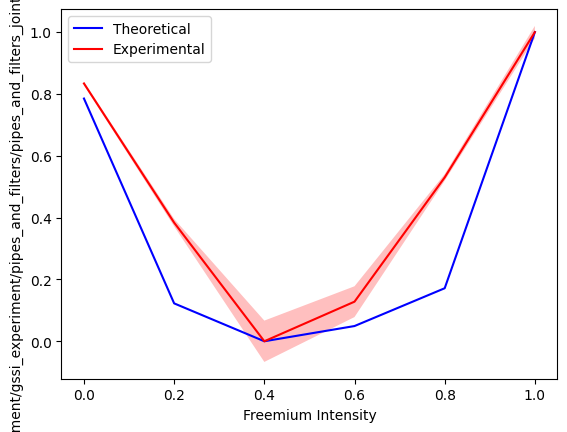

In [10]:
output_path = f'{fig_path}/2cpu_req_delay_norm.png'
nb_helper.create_figure(avg_norm_df, intensity_key, "R0", "avg_latency_ms", output_path)

## Evaluation


### Compares the delay data set using MAPE and Spearman's r


In [11]:
correlation_coefficient, p_value = spearmanr(df["R0"], df["avg_latency_ms"])

# Display the result
print("Spearman's correlation coefficient:")
sig = "significant" if p_value < 0.05 else "insignificant"
print(f"avg_latency_ms: {correlation_coefficient=:.3f} ({p_value=:.3f} ({sig}))")

Spearman's correlation coefficient:
avg_latency_ms: correlation_coefficient=0.980 (p_value=0.000 (significant))


### Mean average percentage error

Intuitively, how off the result is on average.

$\displaystyle M = \frac{1}{n}\sum^n_{t=1} \bigg|\frac{A_t - F_t}{A_t}\bigg|$

Where $n$ is the number of elements, $F_t$ the forecast value, and $A_t$ the actual value.


In [12]:

absolute_mape = stat_helper.mape(df["R0"], df["avg_latency_ms"])
eps = 1
normalized_mape = stat_helper.mape(norm_df["R0"] + eps, norm_df["avg_latency_ms"] + eps)

print(f"{absolute_mape=:.2f}%, {normalized_mape=:.2f}% ({eps=})")

absolute_mape=30.21%, normalized_mape=9.46% (eps=1)


### Mean absolute error

$\displaystyle M = \frac{1}{n}\sum^n_{t=1}\bigg|A_t - F_t\bigg|$

Where $n$ is the number of elements, $F_t$ the forecast value, and $A_t$ the actual value.


In [13]:
absolute_mae = stat_helper.mae(df["R0"], df["avg_latency_ms"])
normalized_mae = 100 * stat_helper.mae(norm_df["R0"], norm_df["avg_latency_ms"])

print(f"{absolute_mae=:.3f}, {normalized_mae=:.2f}%")

absolute_mae=163.419, normalized_mae=13.42%


# CPU Utilization


## Visualization


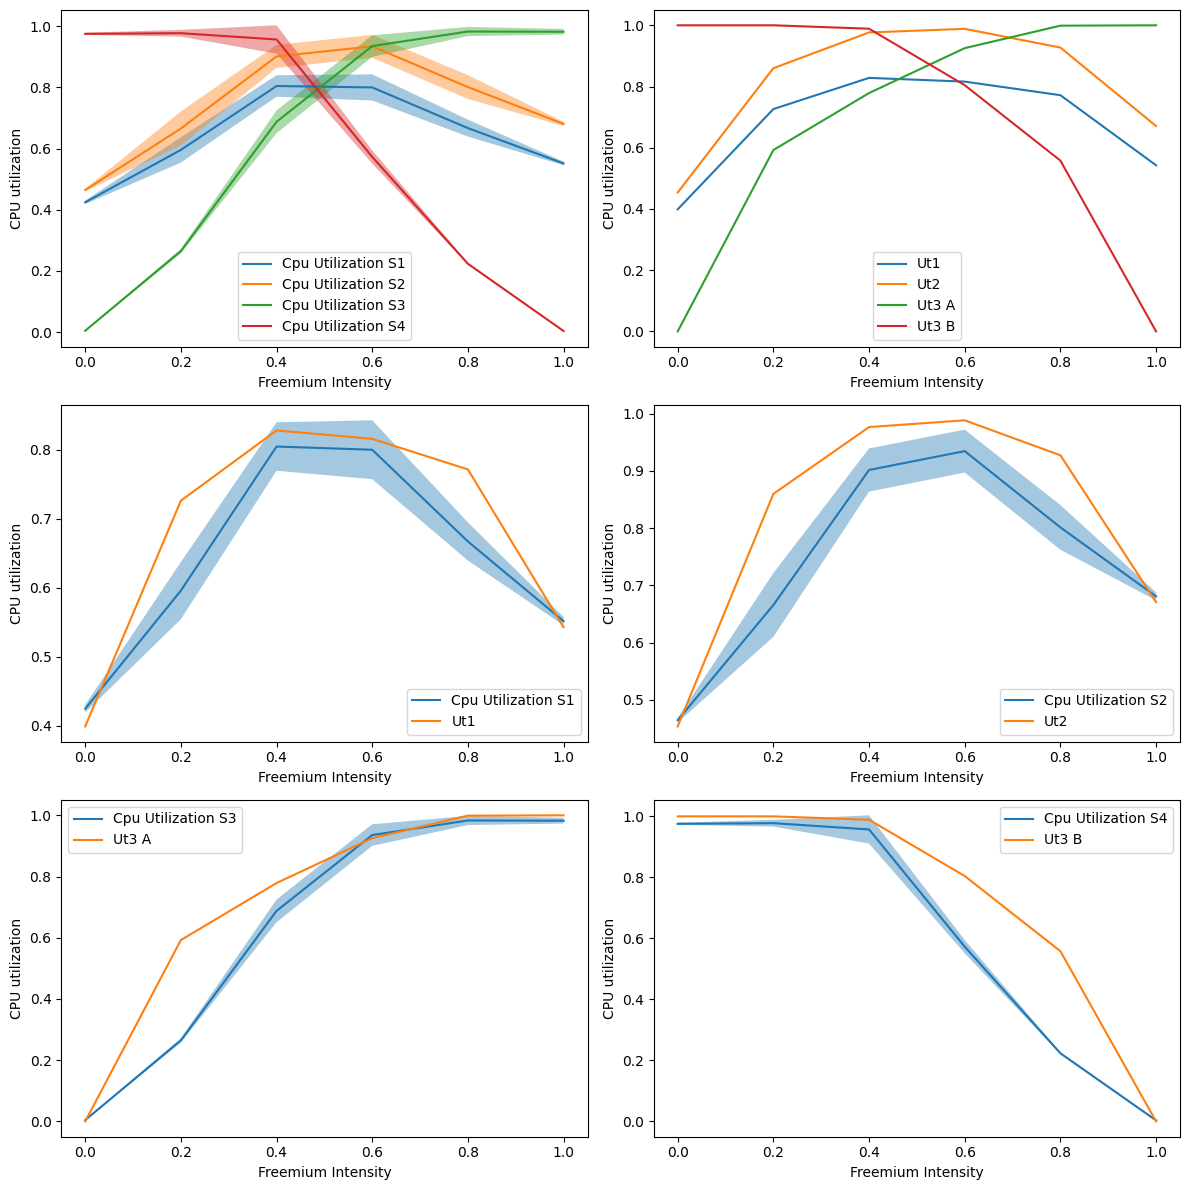

In [14]:
comparison_tuples = [
    (
        "cpu_utilization_s1",
        "cpu_utilization_s2",
        "cpu_utilization_s3",
        "cpu_utilization_s4",
    ),
    ("Ut1", "Ut2", "Ut3_A", "Ut3_B"),
    ("cpu_utilization_s1", "Ut1"),
    ("cpu_utilization_s2", "Ut2"),
    ("cpu_utilization_s3", "Ut3_A"),
    ("cpu_utilization_s4", "Ut3_B"),
]
output_path = f'{fig_path}/2cpu_util_abs.png'
nb_helper.create_plot_comparisons(comparison_tuples, avg_df, intensity_key, output_path)

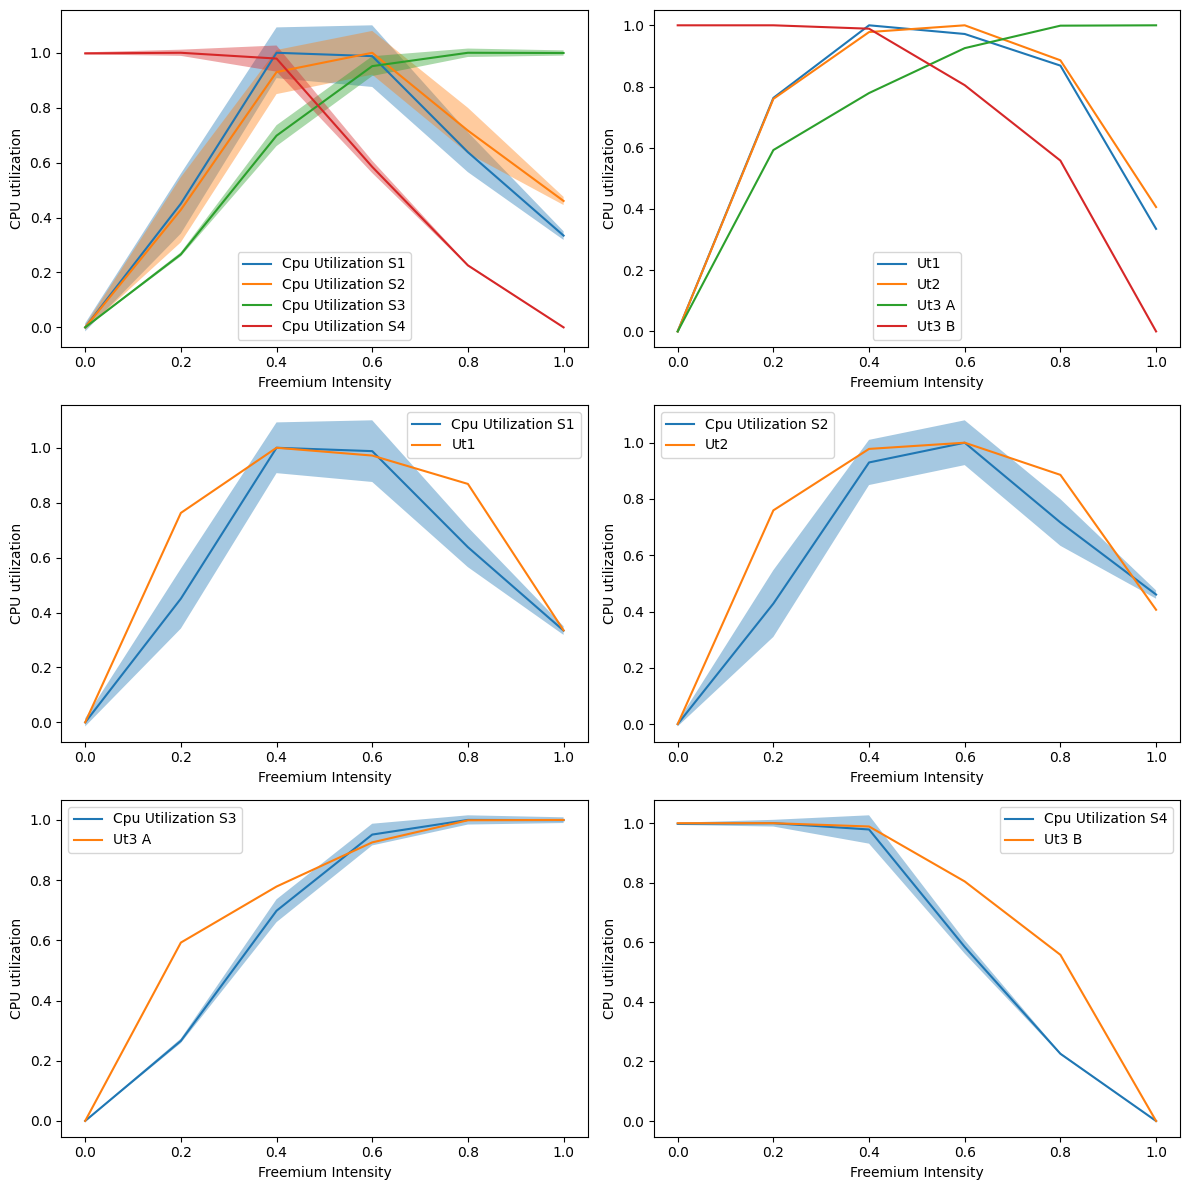

In [15]:
comparison_tuples = [
    (
        "cpu_utilization_s1",
        "cpu_utilization_s2",
        "cpu_utilization_s3",
        "cpu_utilization_s4",
    ),
    ("Ut1", "Ut2", "Ut3_A", "Ut3_B"),
    ("cpu_utilization_s1", "Ut1"),
    ("cpu_utilization_s2", "Ut2"),
    ("cpu_utilization_s3", "Ut3_A"),
    ("cpu_utilization_s4", "Ut3_B"),
]
output_path = f'{fig_path}/2cpu_util_norm.png'
nb_helper.create_plot_comparisons(comparison_tuples, avg_norm_df, intensity_key, output_path)

## Evaluation


In [16]:
comparison_tuples = [
    ("cpu_utilization_s1", "Ut1"),
    ("cpu_utilization_s2", "Ut2"),
    ("cpu_utilization_s3", "Ut3_A"),
    ("cpu_utilization_s4", "Ut3_B"),
]

### Spearman's correlation coefficient


In [17]:
print("Spearman's correlation coefficient:")
for real, expected in comparison_tuples:
    correlation_coefficient, p_value = spearmanr(df[expected], df[real])

    # Display the result
    sig = "significant" if p_value < 0.05 else "insignificant"
    print(f"{real}: {correlation_coefficient:.3f} ({p_value=:.3f} {sig})")

Spearman's correlation coefficient:
cpu_utilization_s1: 0.946 (p_value=0.000 significant)
cpu_utilization_s2: 0.935 (p_value=0.000 significant)
cpu_utilization_s3: 0.947 (p_value=0.000 significant)
cpu_utilization_s4: 0.896 (p_value=0.000 significant)


### Mean average (percentage) error


In [18]:
for real, expected in comparison_tuples:
    mape_score = stat_helper.mape(df[expected], df[real])
    mae_score = 100 * stat_helper.mae(df[expected], df[real])
    print(f"{real}: {mape_score=:.2f}%, {mae_score=:.2f}%")

    eps = 1
    norm_mape_score = stat_helper.mape(norm_df[expected] + eps, norm_df[real] + eps)
    norm_mae_score = 100 * stat_helper.mae(norm_df[expected], norm_df[real])
    print(f"{real}: {norm_mape_score=:.2f}% ({eps=}), {norm_mae_score=:.2f}%\n")

cpu_utilization_s1: mape_score=8.91%, mae_score=5.46%
cpu_utilization_s1: norm_mape_score=7.70% (eps=1), norm_mae_score=11.94%

cpu_utilization_s2: mape_score=10.66%, mae_score=7.83%
cpu_utilization_s2: norm_mape_score=7.56% (eps=1), norm_mae_score=11.65%

cpu_utilization_s3: mape_score=40.65%, mae_score=8.08%
cpu_utilization_s3: norm_mape_score=5.59% (eps=1), norm_mae_score=7.73%

cpu_utilization_s4: mape_score=49.80%, mae_score=10.80%
cpu_utilization_s4: norm_mape_score=7.18% (eps=1), norm_mae_score=9.86%

